In [2]:
%matplotlib inline
import numpy as np
from numpy.random import normal, randint
import matplotlib.pyplot as plt
import time
import sys
import gc
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

# Pyplot config
font = {'family': 'normal',
        'weight': 'normal',
        'size': 14}

plt.rc('font', **font)

# Introduction

# Potential ensemble
In this notebook, we randomly generate an ensemble of potentials to be used in solving Schrodinger's equaiton.

Each potential is generated as Fourier series:
$$ V(x) = \sum\limits_{n=0}^{n_{\rm max}}\left[ V_n^C \cos(n\pi x) +  V_n^S \sin(n\pi x)\right] $$
where the coefficients $\{V_n^{C/S} \,\,|\,\, n \in [1,n_{\rm max}]\}$ are random numbers drawn from a specified probability distribution.

We model the probability distributions for each $V_n^{C/S}$ as a gaussian with zero mean and variance 
$$ \langle {V_n^{C/S}}^2 \rangle = \langle{V_0^{C/S}}^2\rangle e^{-\lambda n} $$
In this way we bias sampled functions toward those with fewer modes. The parameter $\lambda$ controlls the number of modes that contribute to the function space. We note that to represent the function space with the variance specified by $\lambda$, we must have $n_{\rm max} \gg 1/\lambda$.

Created by Hudson Smith on 2016-06-28.
Copyright (c) 2016 ACT. All rights reserved.

## Preliminaries

In [3]:
# Number of potentials:
NV = int(1E4)
# Number of basis states:
NB = 10
ns = np.arange(1, NB+1)
# lambda (variance of Legendre coefficients):
lam = 0.75
# The variance of the n=0 legendre coefficient V_0:
V20 = 10
# The number of x points linearly distributed from -1 to 1
Nx = 100
xs = np.linspace(-1,1,100)
# Number of basis states for the wavefunctions
NBW = 40
nbws = np.arange(1, NBW+1)
# Number of eigenvalues to predict:
# (The neural network predicts the lowest <n_eigs> eigenvalues)
n_eigs = 5

## Mode variances

In [4]:
def modeVariance(n, lam, V20):
    return V20 * np.exp(-lam*(n-1))
V2ns = modeVariance(ns, lam, V20)

/Users/dhudsonsmith/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


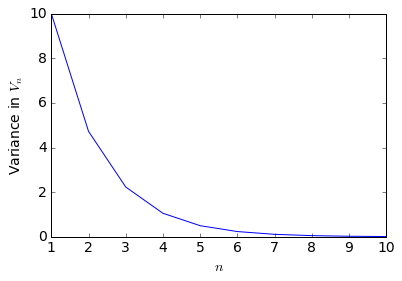

In [5]:
plt.clf()
plt.plot(ns, V2ns)
plt.xlabel("$n$")
plt.ylabel("Variance in $V_n$")
plt.show()

## Generate random numbers
We generate a matrix of numbers. The rows correspond to different random potentials, and the columns correspond to the the coefficients $V_n^{C/S}$ of the Fourier series. After generating the potential coefficients, we plot a histogram of the distribution for a few different values of $V_n^{C/S}$.

In [6]:
stddevs = np.sqrt(V2ns)
VCns = normal(0,stddevs, size = (NV, NB))
VSns = normal(0,stddevs, size = (NV, NB))

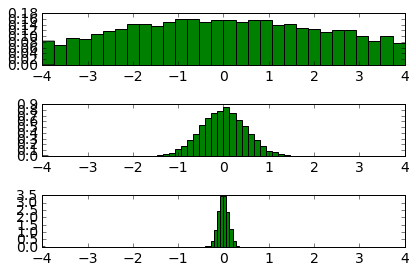

In [7]:
plt.clf()
fig, axes = plt.subplots(nrows = 3, ncols = 1)
ax0,ax1,ax2 = axes.flat

nbins = 30
ax0.hist(VCns[::,0], nbins, normed = 1, facecolor = 'green', alpha = 1, range = [-4,4])
ax1.hist(VCns[::,5], 2*nbins, normed = 1, facecolor = 'green', alpha = 1, range = [-4,4])
ax2.hist(VCns[::,9], 4*nbins, normed = 1, facecolor = 'green', alpha = 1, range = [-4,4])

plt.tight_layout()
plt.show()

## Fourier Series
We calculate the values of the Sine and Cosine function in the Fourier expansion for a grid of $x$-values and for each value of $n$ in our truncated Fourier basis. We do this separately for Sine and Cosine. Letting the number of $x$ grid points be $N_x$, the result is two $N_B\times N_x$ dimensional matrices. One corresponding to the values of the Sine functions, and one corresponding the values of the Cosine functions.

In [8]:
def VS(ns, xs):
    return np.sin(np.pi*np.outer(ns,xs))
def VC(ns, xs):
    return np.cos(np.pi*np.outer(ns,xs))

## Plotting the potentials

In [9]:
# Evaluate the potential on a grid of x coordinates
VSs = VS(ns,xs)
VCs = VC(ns,xs)
Vgrid = np.dot(VSns,VSs) + np.dot(VCns,VCs)

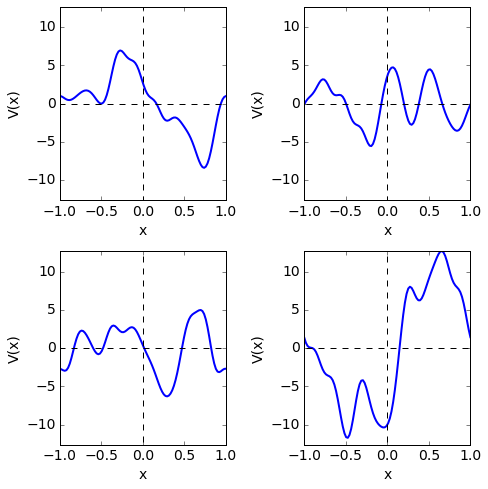

In [10]:
nrows = 2
ncols = 2
nplot = nrows * ncols
Vints = randint(0,NV, nplot)
Vplot = Vgrid[Vints,::]

plt.clf()
fig, axes = plt.subplots(nrows = nrows, ncols = ncols)
fig.set_size_inches(7,7)
subax = axes.flat

for i in range(0,nplot):
        subax[i].plot(xs, Vplot[i], linewidth = 2)
        subax[i].axhline(y=0,xmin=-1,xmax=1, linestyle='dashed' ,color = 'k')
        subax[i].axvline(x=0,ymin=-10,ymax=10, linestyle='dashed' ,color = 'k')
        subax[i].set_xlabel("x")
        subax[i].set_ylabel("V(x)")
        subax[i].set_ylim((-4*np.sqrt(V20),4*np.sqrt(V20)))

plt.tight_layout()
plt.show()
plt.close()

# Eigenvalues
In this notebook we solve Schroedinger's equation for the random potentials generated in the "potentials.ipynb' jupyter notebook.

We solve for the eigenspectrum by representing the Hamiltonian for the system in the basis of "particle in a box" states. Let $H_0$ be the Hamiltonian for the box potential $V_0(x) = 0,\,\,|x|<1$ and $V_0\rightarrow \infty,\,\,{\rm else}$. Schroedinger's equation for the box potential is

$$
(T+V_0)|\psi^0_n\rangle = E_n^0 |\psi^0_n\rangle.
$$

The position-space box eigenstates are

$$
\psi^0_n(x) = \sin\left[\frac{n\pi}{2}(x+1)\right],\,\, |x|\leq 1
$$

Outside the box, the eigenfunctions are zero. The eigenvalues are (using units where $\hbar = m = 1$):

$$
E_n^0 = \frac{n^2\pi^2}{8}
$$


We wish to find the spectrum of the Hamiltonian with the randomly generated potential V. Schroedinger's equation is

$$
\left[T+V_0 + (V - V_0)\right]|\psi\rangle = E |\psi\rangle.
$$

We now expand $|\psi_n\rangle$ in box states:

$$
|\psi\rangle = \sum\limits_{n=1}^\infty a_n |\psi_n^0\rangle.
$$

Projecting out the $\langle\psi_n^0|$ component, we obtain

$$
\sum\limits_{m = 1}^\infty\left[E_n^0\delta_{nm} + \langle\psi_n^0|(V-V_0)| \psi_m^0 \rangle\right] a_m = E_n a_n
$$

Thus, the problem of calculating the spectrum reduces to finding the eigensystem of the matrix $H$ with elements

$$
(H)_{nm} = E_n^0\delta_{nm} + \langle\psi_n^0|(V-V_0)| \psi_m^0 \rangle
$$

As a final step, we note that we have randomly generated the potentials as Fourier series:
$$
V(x) = \sum\limits_{k=1}^{n_{\rm max}} \left[V_n^S\sin(n\pi x) + V_n^C \cos(n\pi x)\right]
$$
Thus, the calculation of the matrix elements of $H$ can be expressed as calculating the matrix elements of the Fourier components, all of which can be done analytically. This we have done in the mathematica notebook titled 'matrixElements.nb'. We use those results here.

## Matrix elements of Fourier components

In [11]:
def matelS(indices):
    n,m,k = indices
    if(m==n-2*k or m==n+2*k or m==-n + 2*k):
        return 0
    else:
        return (-8*(-1)**k*(-1 + (-1)**(m + n))*k*m*n)/ \
            ((2*k + m - n)*(2*k - m + n)*(-2*k + m + n)* \
             (2*k + m + n)*np.pi)

def matelC(indices):
    n,m,k = indices
    if m==n-2*k or m==n+2*k:
        return (-1)**k / 2.
    elif m==-n+2*k:
        return -(-1)**k / 2.
    else:
        return 0.

Precache all of the Fourier component matrix elements:    

In [12]:
# We could use symmetry to reduce calculation time, but time doesn't seem to be an issue here
VSmnk = np.zeros((NBW, NBW, NB));
for n in range(1,NBW+1):
    for m in range(1, NBW+1):
        for k in range(1, NB):
            VSmnk[n-1,m-1,k-1] = matelS([n,m,k])
            
VCmnk = np.zeros((NBW, NBW, NB));
for n in range(1,NBW+1):
    for m in range(1, NBW+1):
        for k in range(1, NB+1):
            VCmnk[n-1,m-1,k-1] = matelC([n,m,k])

## Visualize the matrices 

In [13]:
X, Y = np.meshgrid(nbws,nbws)
ZSs = VSmnk[X-1,Y-1,::]
ZCs = VCmnk[X-1,Y-1,::]
nrows = 2
ncols = 2
nplot = nrows * ncols
z_min, z_max = -np.abs(ZSs).max(), np.abs(ZSs).max()

/Users/dhudsonsmith/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


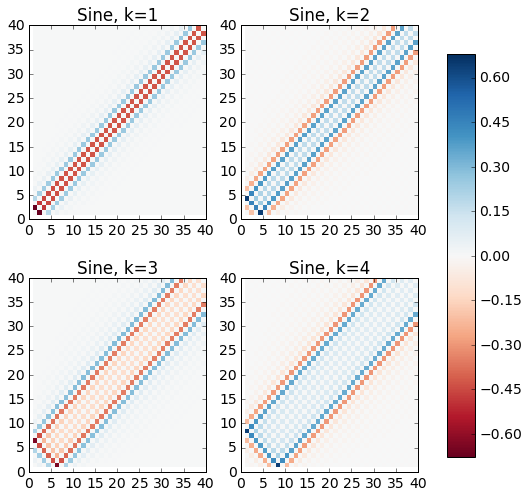

In [14]:
# The Sines
plt.clf()
fig, axes = plt.subplots(nrows = nrows, ncols = ncols)
fig.subplots_adjust(hspace=0.3)
fig.set_size_inches(4*ncols,4*nrows)
subax = axes.flat

for i in range(0,nplot):
        im = subax[i].pcolor(X,Y, ZSs[::,::,i], cmap = 'RdBu', vmin = z_min, vmax = z_max)
        subax[i].set_title("Sine, k="+str(i+1))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
        
plt.show()
plt.close()

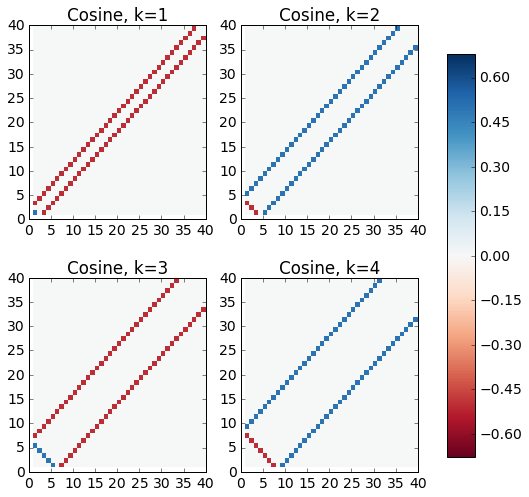

In [15]:
# The Cosines
plt.clf()
fig, axes = plt.subplots(nrows = nrows, ncols = ncols)
fig.subplots_adjust(hspace=0.3)
fig.set_size_inches(4*ncols,4*nrows)
subax = axes.flat

for i in range(0,nplot):
        im = subax[i].pcolor(X,Y, ZCs[::,::,i], cmap = 'RdBu', vmin = z_min, vmax = z_max)
        subax[i].set_title("Cosine, k="+str(i+1))
        
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
        
plt.show()
plt.close()

## The Hamiltonian matrix elements

In [16]:
def E0(n):
    return n**2 * np.pi**2 / 8.

E0ns = np.diag(E0(nbws))

# Be aware: for tensors, np.dot(A,B) sums over the last index of A
# and the SECOND-TO-LAST index of B. It appears that you cannot change this
Vmns = np.dot(VSns, np.transpose(VSmnk,axes=(0,2,1))) \
    + np.dot(VCns, np.transpose(VCmnk,axes=(0,2,1)))

Hmns = E0ns + Vmns

## Visualize the Hamiltonian matrices

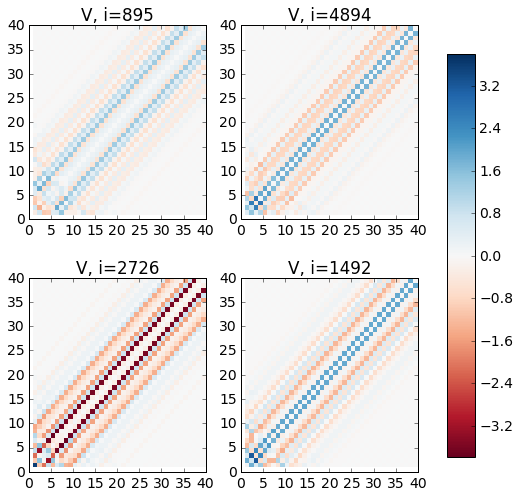

In [17]:
nrows = 2
ncols = 2
nplot = nrows * ncols
Hints = randint(0,NV, nplot)
Hplot = Vmns[Hints]
z_min, z_max = -np.abs(Hplot).max(), np.abs(Hplot).max()
# The Sines
plt.clf()
fig, axes = plt.subplots(nrows = nrows, ncols = ncols)
fig.subplots_adjust(hspace=0.3)
fig.set_size_inches(4*ncols,4*nrows)
subax = axes.flat

for i in range(0,nplot):
        im = subax[i].pcolor(X,Y, Hplot[i], cmap = 'RdBu', vmin = z_min, vmax = z_max)
        subax[i].set_title("V, i="+str(Hints[i]))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
        
#plt.tight_layout()
plt.show()
plt.close()

In [18]:
# Delete some references to (hopefully) free some memory
del VSmnk, VCmnk, Vmns
gc.collect()

26063

## Eigenvalues

In [19]:
eigvals, eigvecs = np.linalg.eig(Hmns)
print("Eigenvalues shape:", eigvals.shape)

Eigenvalues shape: (10000, 40)


In [20]:
# # Sort the eigenvalues in ascending order
# # Apply the same sort to the eigenvectors.
idx = eigvals.argsort()
eigvals = np.asarray([eigvals[i,b] for i,b in enumerate(idx)])
eigvecs = np.asarray([eigvecs[i,:,b] for i,b in enumerate(idx)])
del idx

In [21]:
# Plotting parameters
nrows = 1
ncols = 4
nplot = nrows * ncols
numeigs = 4

# Select some random potentials and eigenvalues to plot
Vints = randint(0,NV, nplot)
Vplot = Vgrid[Vints,::]
eigplot = eigvals[Vints,::]

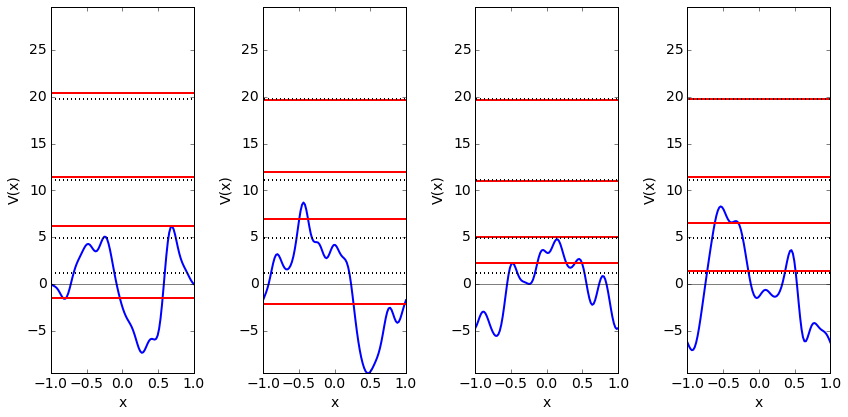

In [22]:
plt.clf()
fig, axes = plt.subplots(nrows = nrows, ncols = ncols)
fig.set_size_inches(3*ncols,6*nrows)
subax = axes.flat

for i in range(0,nplot):
        subax[i].plot(xs, Vplot[i], linewidth = 2)
        subax[i].axhline(y=0,xmin=-1,xmax=1, linestyle='solid' ,color = 'k', lw=0.5)
        for j in range(0, numeigs):
            subax[i].axhline(y=eigplot[i,j], xmin = -1, xmax = 1, 
                             ls = 'solid', color = 'r', lw =2)
            subax[i].axhline(y=E0(j+1), xmin = -1, xmax = 1, 
                             ls = 'dotted', color = 'k', lw = 2)
        subax[i].set_xlabel("x")
        subax[i].set_ylabel("V(x)")
        subax[i].set_ylim((-3*np.sqrt(V20),1.5*E0(numeigs)))

plt.tight_layout()
plt.show()
plt.close()

In [23]:
# Calculate the probability distribution
def psi0(n,x):
    return np.sin(np.pi/2*np.outer(n,x+1))
psiComp = psi0(nbws,xs)
psi=np.dot(eigvecs,psiComp)
prob = psi**2
del psiComp, psi
gc.collect()
print("Size of data: %0.5f MB" % (sys.getsizeof(prob)/1e6))

Size of data: 320.00013 MB


In [24]:
# Plot some random probability distributions
nrows = 1
ncols = 4
nplot = nrows * ncols
Vints = randint(0,NV, nplot)
Vplot = Vgrid[Vints,::]
eigplot = eigvals[Vints,::]
numeigs = 4

/Users/dhudsonsmith/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


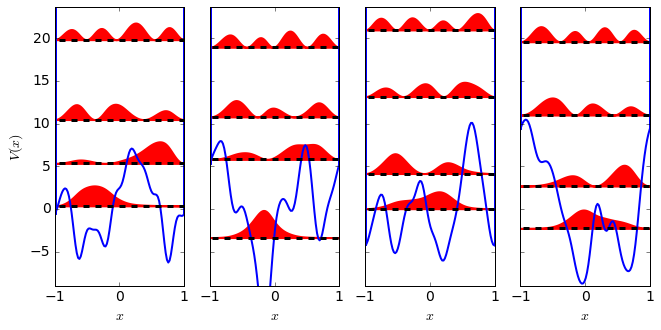

In [25]:
plt.clf()
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharey='all', sharex='all')
fig.set_size_inches(8+8./3.,5)
subax = axes.flat

for i in range(0,nplot):
        subax[i].plot(xs, Vplot[i], linewidth = 2)
        for j in range(0, numeigs):
            subax[i].fill_between(xs, eigplot[i,j], eigplot[i,j]+1.5*prob[Vints[i],j], lw=2, color='r')
            subax[i].get_xaxis().set_ticks([-1,0,1])
            subax[i].axhline(y=eigplot[i,j], xmin = -1, xmax = 1, 
                             ls = 'dashed', color = 'k', lw =3)
            subax[i].vlines(x=-1, ymin = Vplot[i,0], ymax = 3*E0(numeigs), lw=3, color='b')
            subax[i].vlines(x=1, ymin = Vplot[i,-1], ymax = 3*E0(numeigs), lw=3, color='b')
        if i >= (nrows-1)*ncols:
            subax[i].set_xlabel("$x$")
        if i is 0 or i is ncols:
            subax[i].set_ylabel("$V(x)$")
        subax[i].set_ylim((-2.85*np.sqrt(V20),1.2*E0(numeigs)))

#plt.tight_layout()
plt.show()
plt.close()

In [26]:
del prob
gc.collect()

22145

## Distribution of the eigenvalues
We now examine the distribution of the eigenvalues. In particular, we plot the distributions of
$$
\Delta\epsilon_n = \frac{E_n - E_n^0}{\sqrt{\langle V_0^2 \rangle}}
$$
This is the shift in the energy for the $n^{\rm th}$ eigenvalue scaled by the variance in the first Fourier coefficient.

In [27]:
deltaeps = (eigvals-np.diag(E0ns))/np.sqrt(V20)
print("Size of data: %0.5f MB" % (sys.getsizeof(deltaeps)/1e6))

Size of data: 3.20011 MB


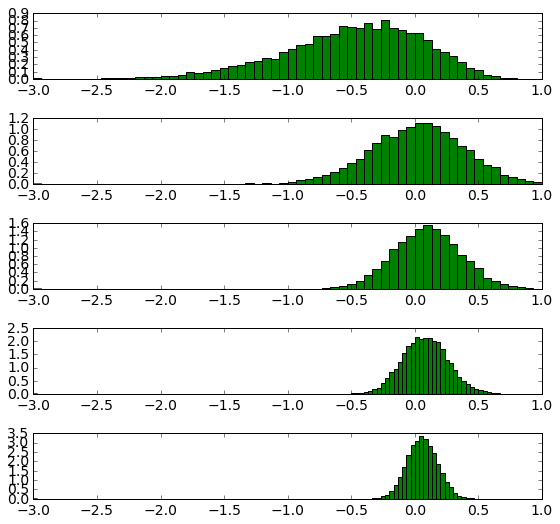

In [28]:
nrows = 5
ncols = 1
nplots = nrows*ncols
plt.clf()
fig, axes = plt.subplots(nrows, ncols)
fig.set_size_inches(8*ncols,1.5*nrows)
subax = axes.flat

nbins = 60
for i in range(0, nrows):
    subax[i].hist(deltaeps[::,i], nbins*int(np.sqrt(i+1)), normed = 1, facecolor = 'green', 
                  alpha = 1, range = [-3,1])

plt.tight_layout()
plt.show()
plt.close()

## Scaled eigenvalues
We now scale each eigenvalue to have zero standard deviation and mean.

In [29]:
eig_mu = np.mean(deltaeps, axis = 0)
eig_std = np.std(deltaeps, axis = 0)

deltaeps_scaled = (deltaeps - eig_mu) / eig_std
print("Size of scaled data: %0.5f MB" % (sys.getsizeof(deltaeps_scaled)/1e6))

Size of scaled data: 3.20011 MB


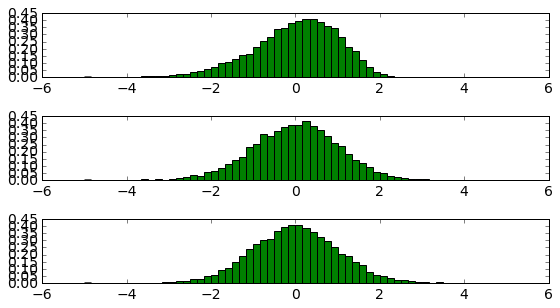

In [30]:
nrows = 3
ncols = 1
nplots = nrows*ncols
plt.clf()
fig, axes = plt.subplots(nrows, ncols)
fig.set_size_inches(8*ncols,1.5*nrows)
subax = axes.flat

nbins = 60
for i in range(0, nrows):
    subax[i].hist(deltaeps_scaled[::,i], nbins, normed = 1, facecolor = 'green', 
                  alpha = 1, range = [-5,5])

plt.tight_layout()
plt.show()
plt.close()

# Neural Network (NN)

## Preprocessing

In [31]:
# Double the dataset using reflection symmetry
VgridFlipped = np.dot(-VSns,VSs) + np.dot(VCns,VCs)

X = np.concatenate( (Vgrid, VgridFlipped) )
y = np.concatenate( (deltaeps_scaled, deltaeps_scaled) )[::,0:n_eigs]

In [32]:
# Split test and train
test_frac = 0.3
random_state = 5
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_frac, random_state=random_state
)
print("X shape, y shape: ", X.shape, y.shape)
print("X_train shape, y_train shape: ", X_train.shape, y_train.shape)
print("X_test shape, y_test shape: ", X_test.shape, y_test.shape)

X shape, y shape:  (20000, 100) (20000, 5)
X_train shape, y_train shape:  (14000, 100) (14000, 5)
X_test shape, y_test shape:  (6000, 100) (6000, 5)


## Building and train the NN

In [33]:
hidden_layers = (100,100)
model =MLPRegressor(hidden_layer_sizes=hidden_layers,
                    activation = 'tanh',
                    algorithm = 'adam',
                    alpha = 0.001,
                    beta_1 = 0.85,
                    beta_2 = 0.9,
                    batch_size = 'auto',
                    max_iter = 500,
                    tol = 1e-8,
                    learning_rate_init = 0.0002,
                    verbose = True
                 )

In [34]:
# Train the network
model.fit(X_train,y_train)

Iteration 1, loss = 0.41409332
Iteration 2, loss = 0.24636510
Iteration 3, loss = 0.21955146
Iteration 4, loss = 0.20539779
Iteration 5, loss = 0.19497041
Iteration 6, loss = 0.18609125
Iteration 7, loss = 0.17844864
Iteration 8, loss = 0.17091423
Iteration 9, loss = 0.16327368
Iteration 10, loss = 0.15595631
Iteration 11, loss = 0.14796092
Iteration 12, loss = 0.14023415
Iteration 13, loss = 0.13236185
Iteration 14, loss = 0.12458345
Iteration 15, loss = 0.11663559
Iteration 16, loss = 0.10937614
Iteration 17, loss = 0.10192822
Iteration 18, loss = 0.09506923
Iteration 19, loss = 0.08842556
Iteration 20, loss = 0.08237869
Iteration 21, loss = 0.07633382
Iteration 22, loss = 0.07106111
Iteration 23, loss = 0.06596848
Iteration 24, loss = 0.06141030
Iteration 25, loss = 0.05713381
Iteration 26, loss = 0.05329227
Iteration 27, loss = 0.04995104
Iteration 28, loss = 0.04669402
Iteration 29, loss = 0.04387513
Iteration 30, loss = 0.04123963
Iteration 31, loss = 0.03900661
Iteration 32, los

MLPRegressor(activation='tanh', algorithm='adam', alpha=0.001,
       batch_size='auto', beta_1=0.85, beta_2=0.9, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(100, 100),
       learning_rate='constant', learning_rate_init=0.0002, max_iter=500,
       momentum=0.9, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, tol=1e-08, validation_fraction=0.1,
       verbose=True, warm_start=False)

## Testing the model

### Calculate errors on the training set as a reference point

In [35]:
# eigenvalue prediction
y_pred_train = model.predict(X_train)
err_train = np.sqrt(np.mean((y_pred_train - y_train)**2, axis=0))
print("Prediction error for each eigenvalue in the training set as ratio of std. dev.: \n", err_train)
print("Uniform average of prediction errors:\n %0.3f" % np.mean(err_train))

# Relative error
eig_pred_train = (y_pred_train*eig_std[0:n_eigs]+eig_mu[0:n_eigs])*np.sqrt(V20)+np.diag(E0ns)[0:n_eigs]
eig_train = (y_train*eig_std[0:n_eigs]+eig_mu[0:n_eigs])*np.sqrt(V20)+np.diag(E0ns)[0:n_eigs]
rel_err_train = np.mean(np.abs((eig_pred_train - eig_train)/eig_train), axis=0)
print("Prediction error for each eigenvalue in the training set as ratio of true value (rel. err.):\n", rel_err_train)

Prediction error for each eigenvalue in the training set as ratio of std. dev.: 
 [ 0.07163374  0.08523627  0.08140112  0.09915849  0.09133805]
Uniform average of prediction errors:
 0.086
Prediction error for each eigenvalue in the training set as ratio of true value (rel. err.):
 [ 0.30627911  0.01620121  0.0041916   0.00205904  0.00080247]


### Calculate errors on the test set

In [36]:
# eigenvalue prediction
y_pred = model.predict(X_test)
err = np.sqrt(np.mean((y_pred - y_test)**2, axis=0))
print("Prediction error for each eigenvalue as ratio of std. dev.: \n", err)
print("Uniform average of prediction errors:\n %0.3f" % np.mean(err))

# Relative error
eig_pred = (y_pred*eig_std[0:n_eigs]+eig_mu[0:n_eigs])*np.sqrt(V20)+np.diag(E0ns)[0:n_eigs]
eig_test = (y_test*eig_std[0:n_eigs]+eig_mu[0:n_eigs])*np.sqrt(V20)+np.diag(E0ns)[0:n_eigs]
rel_err = np.mean(np.abs((eig_pred - eig_test)/eig_test), axis=0)
print("Prediction error for each eigenvalue as ratio of true value (rel. err.):\n", rel_err)

Prediction error for each eigenvalue as ratio of std. dev.: 
 [ 0.08357257  0.09560446  0.0964937   0.11039905  0.11084867]
Uniform average of prediction errors:
 0.099
Prediction error for each eigenvalue as ratio of true value (rel. err.):
 [ 0.3690264   0.01804289  0.00466173  0.00218176  0.00090879]


## Visualizing the results
Plot the some random potentials along with the eigenvalues calculated with Sch. Eqn. and the eigenvalues predicted by the neural network. Choose random potentials from the test set. 

/Users/dhudsonsmith/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


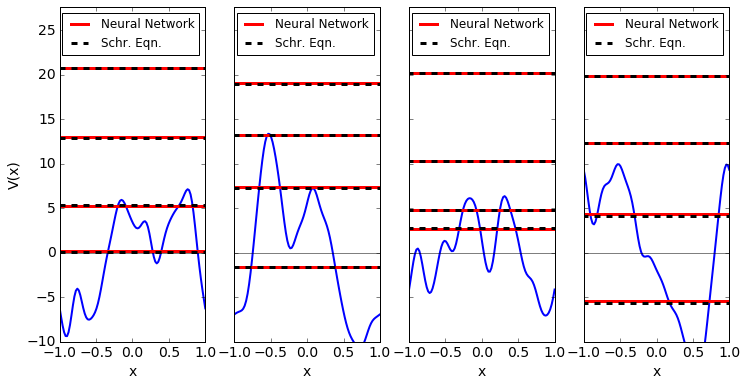

In [37]:
nrows = 1
ncols = 4
nplot = nrows * ncols
indplt = randint(0,X_test.shape[0], nplot)
numeigsplt = 4

plt.clf()
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharey=True)
fig.set_size_inches(12,6)
subax = axes.flat

for i in range(0, len(indplt)):
        subax[i].plot(xs, X_test[indplt[i]], linewidth = 2, label='$V(x)$')
        subax[i].axhline(y=0,xmin=-1,xmax=1, linestyle='solid' ,color = 'k', lw=0.5)
        for j in range(0, numeigsplt):
            lastaxNN = subax[i].axhline(y=eig_pred[indplt[i],j], xmin = -1, xmax = 1, 
                             ls = 'solid', color = 'r', lw = 3, label = 'Neural Network')
            lastaxSE = subax[i].axhline(y=eig_test[indplt[i],j], xmin = -1, xmax = 1, 
                             ls = 'dashed', color = 'k', lw =3, label = 'Schr. Eqn.')

        subax[i].set_xlabel("x")
        if i==0:
            subax[i].set_ylabel("V(x)")
        subax[i].set_ylim((-V20, 1.4*E0(numeigsplt)))
        subax[i].legend([lastaxNN, lastaxSE], ["Neural Network", "Schr. Eqn."], fontsize=12)

# plt.tight_layout();
plt.show();
plt.draw()

## Some special cases

### Square well

In [70]:
Vtest = np.asarray([np.zeros(Nx)])

# eigenvalue prediction
y_square_pred = model.predict(Vtest)[0]
y_square_test = ((np.diag(E0ns)[0:n_eigs] - np.diag(E0ns)[0:n_eigs])/np.sqrt(V20) - eig_mu[0:n_eigs])/eig_std[0:n_eigs]
err_square = np.sqrt((y_square_pred - y_square_test)**2)
print("Prediction error for each eigenvalue as ratio of std. dev.: \n", err_square)
print("Uniform average of prediction errors:\n %0.3f" % np.mean(err_square))

# Relative error
eig_square_pred = (y_square_pred*eig_std[0:n_eigs]+eig_mu[0:n_eigs])*np.sqrt(V20)+np.diag(E0ns)[0:n_eigs]
eig_square_test = (y_square_test*eig_std[0:n_eigs]+eig_mu[0:n_eigs])*np.sqrt(V20)+np.diag(E0ns)[0:n_eigs]
rel_err = np.abs((eig_square_pred - eig_square_test)/eig_square_test)
print("Prediction error for each eigenvalue as ratio of true value (rel. err.):\n", rel_err)

Prediction error for each eigenvalue as ratio of std. dev.: 
 [ 0.01069452  0.02906462  0.02995988  0.01118822  0.01094112]
Uniform average of prediction errors:
 0.018
Prediction error for each eigenvalue as ratio of true value (rel. err.):
 [ 0.01508737  0.00683368  0.0022653   0.00032282  0.00013518]
